# Background

In this notebook we want to see why the out-of-phase correlations are not showing up in the scattergrams.

In [1]:
%pylab inline
import os,sys,re
import pickle
from builtins import sum as bsum
from importlib import reload
from collections import defaultdict, namedtuple
from matplotlib.gridspec import GridSpec
import matplotlib.transforms as mtransforms
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8,3)


Populating the interactive namespace from numpy and matplotlib


In [2]:
import units; reload(units); UNITS = units.UNITS;
HZ = UNITS.Hz
SEC= UNITS.s
M  = UNITS.m
UM = UNITS.um

In [3]:
os.environ["FISHER_PLUMES"] = os.path.join(os.environ["GIT"],"fisher-plumes")
os.chdir(os.environ["FISHER_PLUMES"])


In [4]:
import boulder;   reload(boulder)
import crick;     reload(crick)
import surrogate; reload(surrogate)
import fisher_plumes_tools as fpt;      reload(fpt)
import fisher_plumes_figs  as fpf;      reload(fpf);
import fisher_plumes_fig_tools as fpft; reload(fpft)
import fisher_plumes as fp;             reload(fp)
import utils; reload(utils); from utils import dict_update, dict_update_from_field
import proc; reload(proc);
FisherPlumes = fp.FisherPlumes
crick.logger.setLevel(logging.DEBUG)
fp.logger.setLevel(logging.INFO)


INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_manuscript.h5         : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_manuscript.h5         : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:crimgrid_w1                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w2                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w3                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w4                                     : y0 - y9 (16 datasets)


INFO:crick:n12T                                            : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12Tslow                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12dishT                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n16T                                            : Y0.440 - Y0.560 (16 datasets)


INFO:crick:n16Tslow                                        : Y0.440 - Y0.560 (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:crimgrid_w1                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w2                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w3                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w4                                     : y0 - y9 (16 datasets)


INFO:crick:n12T                                            : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12Tslow                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12dishT                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n16T                                            : Y0.440 - Y0.560 (16 datasets)


INFO:crick:n16Tslow                                        : Y0.440 - Y0.560 (16 datasets)


INFO:surrogate:Surrogate simulation data available for: ['no_info', 'one_info', 'two_info', 'high', 'spike_and_slab', 'blue', 'red', 'all_equal']


INFO:surrogate:Surrogate simulation data available for: ['no_info', 'one_info', 'two_info', 'high', 'spike_and_slab', 'blue', 'red', 'all_equal']


In [5]:
window_length = 1 * UNITS.second
windows       = ['boxcar', 'hann', ('kaiser',9), ('kaiser', 16)]
window_shape  = windows[1]
fit_k         = True


In [6]:
to_use = {"s=w_q0":{"sim_name":"surr_quad",      "surrogate_k": 0, "phi":0},
          "s=w_q1":{"sim_name":"surr_quad",      "surrogate_k": 0, "phi":pi/3},
}


In [7]:
[f.logger.setLevel(logging.WARN) for f in [crick, boulder,fp]];

data =  {k:FisherPlumes(proc.load_data(init_filter = v,
                                       compute_filter = {"window_shape":window_shape,
                                                         "window_length":window_length,
                                                         "fit_k":fit_k}
)[0]) for k,v in to_use.items()}

[f.logger.setLevel(logging.INFO) for f in [crick, boulder,fp]];


                    proc 2023/08/15 13:18:08     INFO: Loading init_filter={'sim_name': 'surr_quad', 'surrogate_k': 0, 'phi': 0} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/s=w_q.1/d629307dbf67846a.p


                    proc 2023/08/15 13:18:10     INFO: Returning 1 results.


INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-59.105481

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-59.105481

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -5.849007

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -4.574717

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ 33.909967

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-75.398814

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-44.311011

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-41.766802

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[19.70954707]

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -8.25426173],

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[   7.4133005

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[  8.7539695

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-53.6985321

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-77.0756848

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-26.8604322

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-23.2495403

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ 14.9550891

                    proc 2023/08/15 13:18:10     INFO: Loading init_filter={'sim_name': 'surr_quad', 'surrogate_k': 0, 'phi': 1.0471975511965976} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/s=w_q.2/11fb5bc0b49359a5.p


                    proc 2023/08/15 13:18:11     INFO: Returning 1 results.


INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 1.0471975511965976}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 1.0471975511965976}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 1.0471975511965976}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 1.0471975511965976}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 1.0471975511965976}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 1.0471975511965976}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 1.0471975511965976}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 1.0471975511965976}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 1.0471975511965976}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': arr

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 1.0471975511965976}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 1.0471975511965976}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': arr

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 1.0471975511965976}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': ar

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 1.0471975511965976}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': ar

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 1.0471975511965976}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': ar

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 1.0471975511965976}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': ar

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 1.0471975511965976}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': ar

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0, 'phi': 1.0471975511965976}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': ar

s=w_q0
Mapped 2 Hz to index 2.


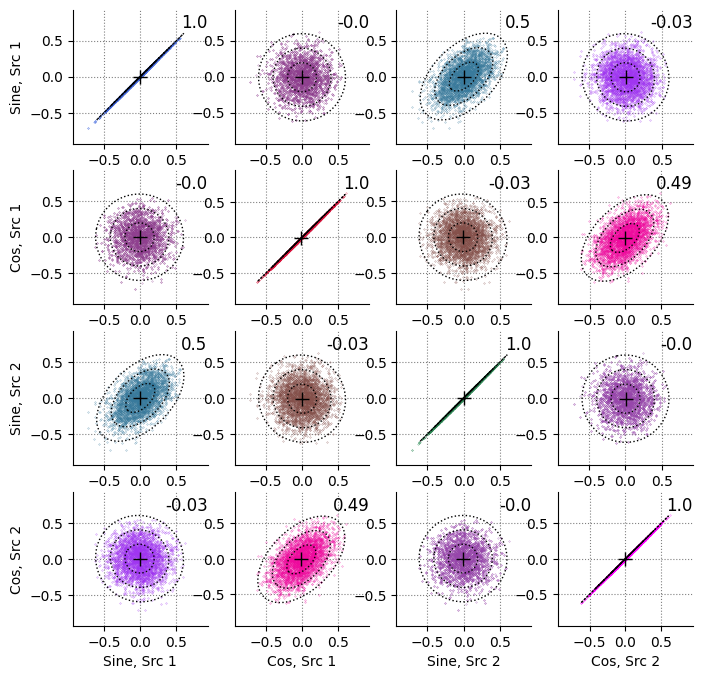

s=w_q1
Mapped 2 Hz to index 2.


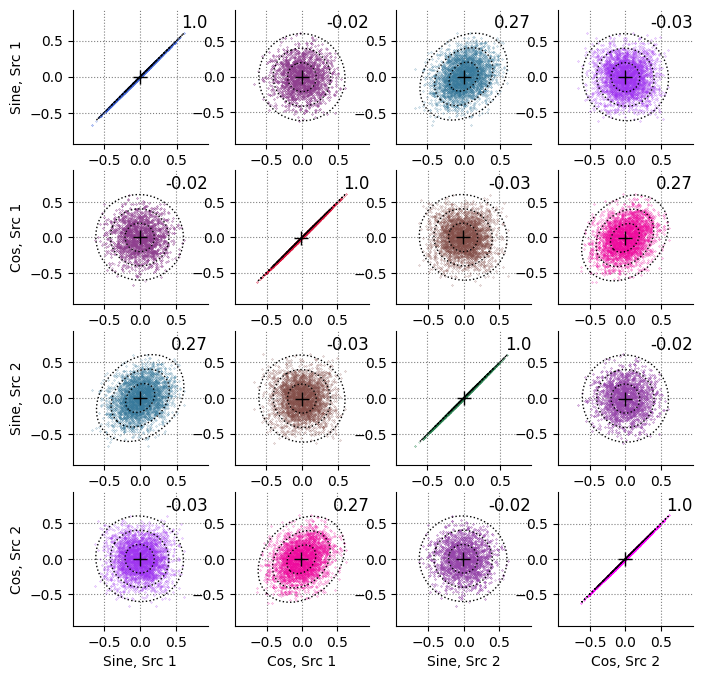

In [8]:
iprb = 0
reload(fpft)
reload(fpf)
freqs_to_plot = [2 * UNITS.Hz]#, 5 * UNITS.Hz, 8 * UNITS.Hz, 10 * UNITS.Hz]
for name, F in sorted(data.items()):
    print(name)
    #if name != "s=w_q1":
    #    print("Skipping surrogate data.")
    #    continue
    for which_freq in freqs_to_plot:
        ifreq = F.freqs2inds([which_freq])[0]
        print(f"Mapped {which_freq} to index {ifreq}.")
        ax = fpf.plot_scattergram([F.ss[iprb], F.cc[iprb]],
                                  ifreq,
                                  0,
                                  F.pairs_um,
                                  F.pitch_string,
                                  figsize=(8,8),
                                  dist_col_scale = 120000,
                                  markersize = 0.2,
                                  cols = ["royalblue","crimson", "seagreen", "magenta"],
                                  coef_names = {0:"Sine", 1:"Cos"},
                                  lim_scale = 2.,
                                  print_fun = np.corrcoef,
                                  )
        sys.stdout.flush(); plt.show()


# Let's generate some coefficents


In [31]:
import yaml

from utils import eval_fields
yaml_file = "proc/s=w_q.2.yaml"
with open(yaml_file, "r") as f:
    yaml_data = yaml.load(f, Loader=yaml.FullLoader)

spec = eval_fields(yaml_data, context=globals())
print(spec["init"])

{'sim_name': 'surr_quad', 'freq_max': <Quantity(20, 'hertz')>, 'which_coords': [<Quantity([1. 0.], 'meter')>], 'n_sources': 16, 'pairs_mode': 'unsigned', 'n_bootstraps': 50, 'random_seed': 0, 'surrogate_k': 0, 'phi': 1.0471975511965976}


In [32]:
reload(surrogate)
surrogate.logger.setLevel("WARNING")
surr = surrogate.SurrogateSimulationData("quad", n_sources=16)
surr.surr_data_args["surrogate_k"] = spec["init"]["surrogate_k"]
surr.surr_data_args["phi"] = spec["init"]["phi"]
surr.generate_surrogate_data()


INFO:surrogate:Surrogate simulation data available for: ['no_info', 'one_info', 'two_info', 'high', 'spike_and_slab', 'blue', 'red', 'all_equal']


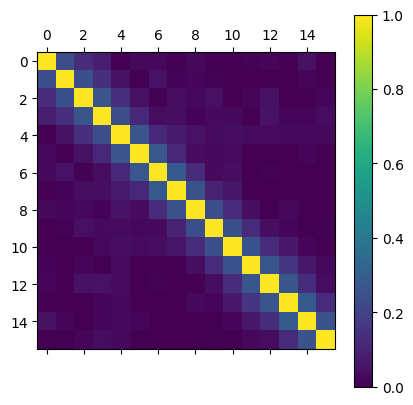

In [33]:
matshow(corrcoef(surr.X), vmin=0,vmax=1); colorbar()

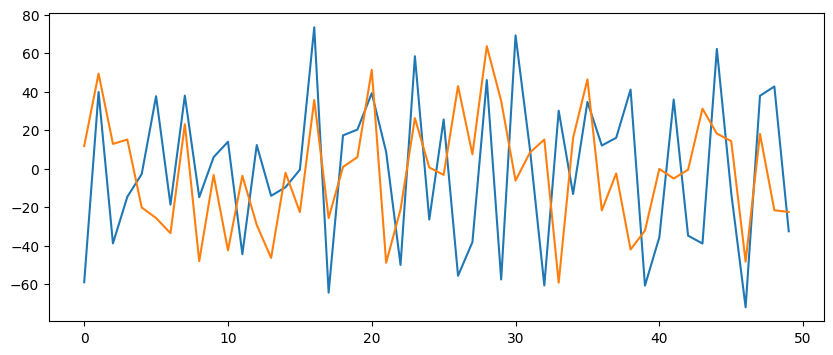

In [34]:
figure(figsize=(10,4))
plot(surr.X[:2,:50].T)

Text(0.5, 1.0, 's0, c1')

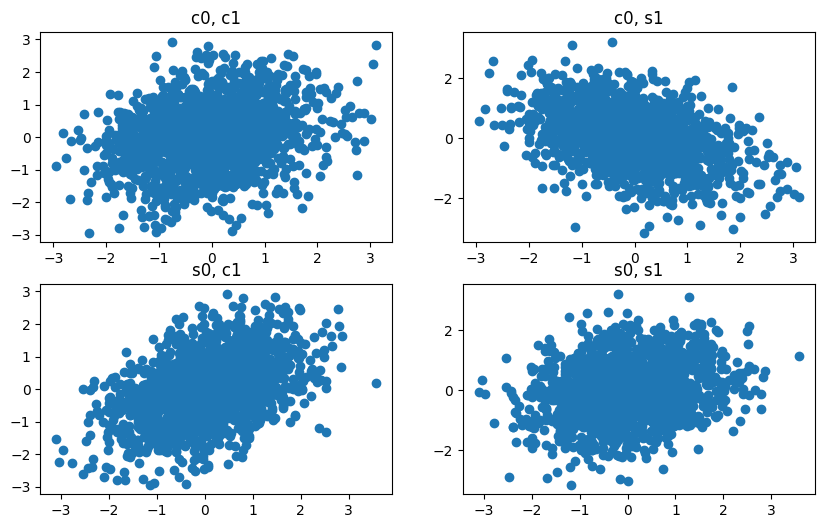

In [35]:
figure(figsize=(10,6))
subplot(2,2,1); scatter(surr.c[:,0], surr.c[:,1]); title("c0, c1")
subplot(2,2,4); scatter(surr.s[:,0], surr.s[:,1]); title("s0, s1")
subplot(2,2,2); scatter(surr.c[:,0], surr.s[:,1]); title("c0, s1")
subplot(2,2,3); scatter(surr.s[:,0], surr.c[:,1]); title("s0, c1")

In [36]:
fp = FisherPlumes(**spec["init"])

           fisher_plumes 2023/08/15 13:29:25     INFO: ****** LOADING sim_name='surr_quad' ******


           fisher_plumes 2023/08/15 13:29:25     INFO: 1 surr_quad_pitch = 0.025 m


           fisher_plumes 2023/08/15 13:29:25     INFO: 1 surr_quad_pitch = 2.5 cm


           fisher_plumes 2023/08/15 13:29:25     INFO: 1 surr_quad_pitch = 25.0 mm


           fisher_plumes 2023/08/15 13:29:25     INFO: 1 surr_quad_pitch = 25000.0 µm


     fisher_plumes_tools 2023/08/15 13:29:25     INFO: Using absolute py coordinates.


     fisher_plumes_tools 2023/08/15 13:29:29     INFO: Computing pairs for len(yvals)=16 from -56250 to 56250 using pairs_mode='unsigned'.


     fisher_plumes_tools 2023/08/15 13:29:29     INFO: Pooling data across pair distances that are <= 0 apart.


     fisher_plumes_tools 2023/08/15 13:29:29    DEBUG: dd=[[0], [7500], [15000], [22500], [30000], [37500], [45000], [52500], [60000], [67500], [75000], [82500], [90000], [97500], [105000], [112500]]


     fisher_plumes_tools 2023/08/15 13:29:29    DEBUG: key=0: grouped distances = [0]


     fisher_plumes_tools 2023/08/15 13:29:29    DEBUG: key=7500: grouped distances = [7500]


     fisher_plumes_tools 2023/08/15 13:29:29    DEBUG: key=15000: grouped distances = [15000]


     fisher_plumes_tools 2023/08/15 13:29:29    DEBUG: key=22500: grouped distances = [22500]


     fisher_plumes_tools 2023/08/15 13:29:29    DEBUG: key=30000: grouped distances = [30000]


     fisher_plumes_tools 2023/08/15 13:29:29    DEBUG: key=37500: grouped distances = [37500]


     fisher_plumes_tools 2023/08/15 13:29:29    DEBUG: key=45000: grouped distances = [45000]


     fisher_plumes_tools 2023/08/15 13:29:29    DEBUG: key=52500: grouped distances = [52500]


     fisher_plumes_tools 2023/08/15 13:29:29    DEBUG: key=60000: grouped distances = [60000]


     fisher_plumes_tools 2023/08/15 13:29:29    DEBUG: key=67500: grouped distances = [67500]


     fisher_plumes_tools 2023/08/15 13:29:29    DEBUG: key=75000: grouped distances = [75000]


     fisher_plumes_tools 2023/08/15 13:29:29    DEBUG: key=82500: grouped distances = [82500]


     fisher_plumes_tools 2023/08/15 13:29:29    DEBUG: key=90000: grouped distances = [90000]


     fisher_plumes_tools 2023/08/15 13:29:29    DEBUG: key=97500: grouped distances = [97500]


     fisher_plumes_tools 2023/08/15 13:29:29    DEBUG: key=105000: grouped distances = [105000]


     fisher_plumes_tools 2023/08/15 13:29:29    DEBUG: key=112500: grouped distances = [112500]


     fisher_plumes_tools 2023/08/15 13:29:29     INFO: 16 pair distances before pool, 16 pair distances after pooling.


     fisher_plumes_tools 2023/08/15 13:29:29     INFO: Removing duplicates in pairs dictionary.


           fisher_plumes 2023/08/15 13:29:29     INFO: list(self.sims.keys())=[-56250, -48750, -41250, -33750, -26250, -18750, -11250, -3750, 3750, 11250, 18750, 26250, 33750, 41250, 48750, 56250]


In [37]:
fp.set_window(50)
fp.compute_stft()
fp.compute_trig_coefs(istart=0, window=('hann'))

           fisher_plumes 2023/08/15 13:29:34     INFO: Window set to self.wnd=50.


           fisher_plumes 2023/08/15 13:29:34     INFO: Computing spectrum.


           fisher_plumes 2023/08/15 13:29:34     INFO: Computing trig coefficients for surr_quad with istart=0 and window='hann' and z_score=True and kwargs={} 


           fisher_plumes 2023/08/15 13:29:34     INFO: Computing coefficients for 1 probes.


In [43]:
ds = sorted(fp.ss[0].keys())
ds

[-56250,
 -48750,
 -41250,
 -33750,
 -26250,
 -18750,
 -11250,
 -3750,
 3750,
 11250,
 18750,
 26250,
 33750,
 41250,
 48750,
 56250]

Text(0.5, 1.0, 's0, c1')

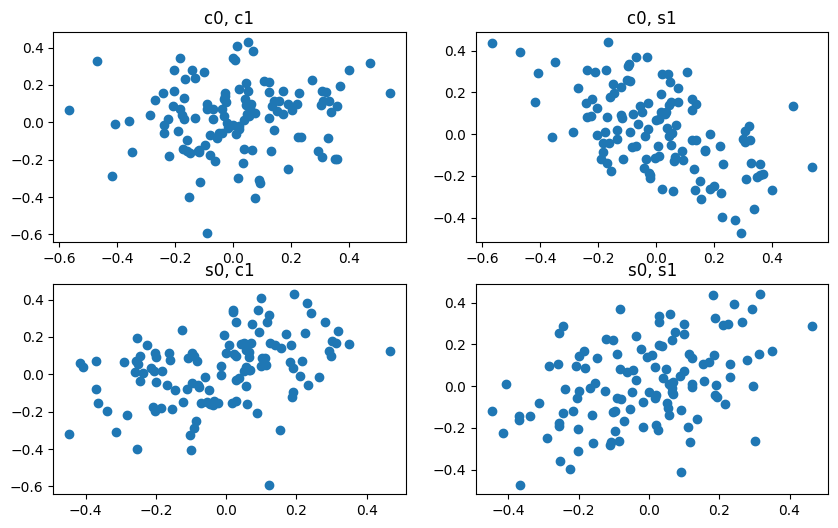

In [51]:
di = 1
ifreq = 2
c0 = fp.cc[0][ds[di]][0][:,ifreq]
c1 = fp.cc[0][ds[di+1]][0][:,ifreq]
s0 = fp.ss[0][ds[di]][0][:,ifreq]
s1 = fp.ss[0][ds[di+1]][0][:,ifreq]
figure(figsize=(10,6))
subplot(2,2,1); scatter(c0, c1); title("c0, c1")
subplot(2,2,4); scatter(s0, s1); title("s0, s1")
subplot(2,2,2); scatter(c0, s1); title("c0, s1")
subplot(2,2,3); scatter(s0, c1); title("s0, c1")